## Importing Libraries and Custom packages 📦

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Github/Biometric

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Github/Biometric


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from sklearn import svm, metrics
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from FUNC_script import *
from Injection import Poison_Attack

## Loading Face-Net model and System Face detector(SVM- Oneclass)

In [3]:
# Load FaceNet Model
model = load_model('Template_poisoning/model/facenet_keras.h5', compile= False)
model.trainable= False

# Load Svm Classifier
clf = svm.OneClassSVM(kernel='linear', nu= 0.06)

# Load Svm Classifier
clf_pca = svm.OneClassSVM(kernel='rbf', nu= 0.12)

## Data Loading and Visualization🔍

In [4]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)


# 128 -> 2 dim pca 
def convert_pca(x, ret= False):
  pca= PCA(n_components=2)
  x= pca.fit_transform(x)
  if ret:
    return pca, x
  return x

In [5]:
# Data  Loading
def load_data(dir):
  X=[]
  for i, sample in enumerate(os.listdir(dir)):
    image= load_img(os.path.join(dir, sample))
    image = cv2.resize(image, (160, 160))
    X.append(image/255.0)
  return np.array(X)

adv_x= load_data('Template_poisoning/Croped_data/adversary_images')
adv_x_copy= adv_x.copy() # Copy of X
print('Adversarial Batch:',adv_x.shape)

Target_x= load_data('Template_poisoning/Croped_data/target_images')
print('Target Batch:',Target_x.shape)

Adversarial Batch: (24, 160, 160, 3)
Target Batch: (75, 160, 160, 3)


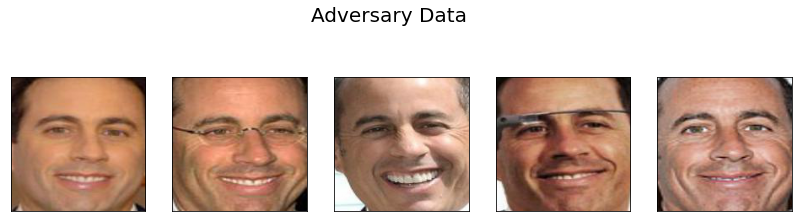

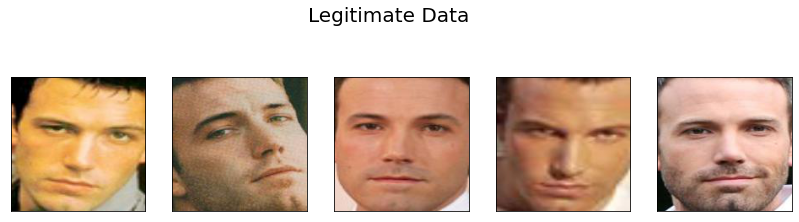

In [6]:
# Image Visualization
f, ax= plt.subplots(1, 5, figsize=(14, 4))
for i in range(5):
  ax[i].imshow(adv_x[i+5])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.suptitle('Adversary Data', size= 20)
plt.show()


f, ax= plt.subplots(1, 5, figsize=(14, 4))
for i in range(5):
  ax[i].imshow(Target_x[i])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.suptitle('Legitimate Data', size= 20)
plt.show()

## Data(legitimate) fitting in System detectoin model 

1. We decide to use a linear kernel for SVM as this was the best performing one in terms of recognition performance.



2.  To account for the age
of samples in the template, i.e., older samples might be considered
less relevant than recent samples, we include two different weighting schemes: (i) **flat**, (ii) **sigmoid**.
   *  In the flat weighting schemes,
each sample in the template is considered equally important in the
decision.
   *  In the sigmoid scheme the weight of each sample (*wi*)
is computed with a sigmoid function prioritizing recent samples

In [7]:
# Main System Face Detector
sys_clf= Poison_Attack(clf, model.predict(Target_x))
sys_clf.fit(sample_weight= 'flat')

### Sample & Model 2D Boundary/classification Wall Visualization 

In [8]:
Target_x_128= model.predict(Target_x)
adv_x_128=  model.predict(adv_x)

# Target_x_2= convert_pca(Target_x_128)
# adv_x_2= convert_pca(adv_x_128)

mix_128= np.concatenate([adv_x_128, Target_x_128])  #0->23(adv_x_128), 24->36(Target_x_128)
pca, mix_2= convert_pca(mix_128, ret= True)

clf_pca.fit(mix_2[24:, :])
print("Svm (OneClassSVM) 'clf_pca' Trained/Fitted sucessfully for Visulization Purpose")

Svm (OneClassSVM) 'clf_pca' Trained/Fitted sucessfully for Visulization Purpose


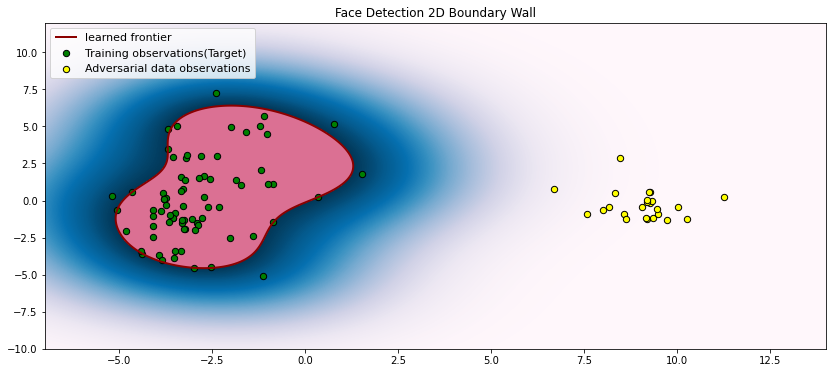

In [9]:
xx, yy = np.meshgrid(np.linspace(-12, 14, 1000), np.linspace(-14, 12, 1000))

# plot the line, the points, and the nearest vectors to the plane
Z = clf_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize= (14, 6))
plt.title("Face Detection 2D Boundary Wall")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 400), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(mix_2[24:, 0], mix_2[24:, 1], c='green', s=s, edgecolors='k')
b2 = plt.scatter(mix_2[:24, 0], mix_2[:24, 1], c='yellow', s=s,edgecolors='k')


plt.axis('tight')
plt.xlim((-7, 14))
plt.ylim((-10, 12))
plt.legend([a.collections[0], b1, b2],
           ["learned frontier", "Training observations(Target)",
            "Adversarial data observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.show()

##  Poisoning Sample Generation

In [10]:
def loss_object(pred, label, delta_x, direction= False):
  # Loss= euclidean distance + Delta_x pixel Variance
  dist= Euclidean_dist(pred, label)
  variance= Sample_variance(delta_x)
  if direction:
    sc= tf.math.subtract(1.0, tf.math.divide(1.0, label.shape[0]))

    vector_mean= tf.math.multiply(dist, sc)
   
    target_dir= tf.math.multiply(vector_mean, dist)
    Loss= tf.math.add(target_dir, tf.cast(variance, dist.dtype))
    return Loss

  Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
  return Loss


def back_propagate(model, X, mask, delta_x, label, direction= False):
  with tf.GradientTape() as g:
      g.watch(delta_x)
      X_batch= Generate_sample(X, delta_x, mask)
      feature= model(X_batch)
      loss= loss_object(pred= feature, label= label, delta_x= delta_x, direction= direction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = g.gradient(loss, delta_x)
  return gradient, tf.reduce_mean(loss).numpy()

In [11]:
adv_centroid= Centroid(adv_x_128, axis= 0) #(1 x 128)
print(adv_centroid.shape)
adv_centroid= Generate_target(adv_centroid, batch_size=adv_x.shape[0]) #(24 x 128)
print(adv_centroid.shape)

# centre of target sample features
Target_sample= Centroid(Target_x_128)
Target_sample= Generate_target(Target_sample, batch_size= adv_x.shape[0])
Target_sample.shape

(128,)
(24, 128)


(24, 128)

In [12]:
def schedule_lr(Lambda_target, ep):
  if ep>= 300:
      return 0.06
  elif (ep<20) or (ep>210):
    return 0.1
  elif (ep>20) and (ep<210):
      return 0.2
  else:
    return Lambda_target

In [13]:
def Get_pubertation(model, adv_x, adv_centroid, Target_x, direction= True, epoch= 160, Lambda_x= 0.5, Lambda_target= 0.2):
  # Get Binary  Mask
  mask= load_img('Template_poisoning/final_mask.png')                           #Sacle(0-255), RGB
  mask= mask/255.0

  delta_x= np.random.uniform(low=0.0, high=1.0, size=adv_x.shape)               # Scale(0-1)

  # Tf Variables
  X= tf.Variable(adv_x, dtype=tf.float64)
  delta_x= tf.Variable(delta_x, dtype=tf.float64)
  mask= tf.Variable(mask, dtype=tf.float64)
  # Xc= tf.Variable(adv_centroid)
  # Target= tf.Variable(Target_x)
  print("Processing Pubertations for Adversarial's centroid")
  for ep  in range(epoch+1):
    grad, loss= back_propagate(model, X, mask, delta_x,
                               adv_centroid, direction= True)
    # Gradient step
    delta_x= delta_x - Lambda_x*grad
    if ep%20 == 0:
      print('Epoch: {}  Loss: {:.3f}'.format((ep), loss))


  delta=[]
  delta.append(tf.identity(delta_x))
  print()
  print("Processing Pubertation Towards Target's pubertation")

  for ep  in range(int(3*epoch+ 1)):
    grad, loss= back_propagate(model, X, mask, delta_x,
                               Target_x, direction= True)
    # Gradient step
    Lambda_target= schedule_lr(Lambda_target, ep)
    delta_x= delta_x - Lambda_target*grad
    if ep < 200:
      delta.append(tf.identity(delta_x))
    else:
      if ep%2==0:
         delta.append(tf.identity(delta_x))

    if ep%20 == 0:
      print('Epoch: {}, Loss: {}'.format((ep), loss))


  return delta



In [14]:
pubertation_list= Get_pubertation(model, adv_x, adv_centroid, Target_x= Target_sample,
                   direction= True, epoch= 160, Lambda_x= 0.5, Lambda_target= 0.2)

Processing Pubertations for Adversarial's centroid
Epoch: 0  Loss: 258.086
Epoch: 20  Loss: 129.004
Epoch: 40  Loss: 85.261
Epoch: 60  Loss: 55.058
Epoch: 80  Loss: 38.094
Epoch: 100  Loss: 32.257
Epoch: 120  Loss: 28.999
Epoch: 140  Loss: 27.323
Epoch: 160  Loss: 27.104

Processing Pubertation Towards Target's pubertation
Epoch: 0, Loss: 176.23472595214844
Epoch: 20, Loss: 78.99764251708984
Epoch: 40, Loss: 70.14110565185547
Epoch: 60, Loss: 64.26496124267578
Epoch: 80, Loss: 61.696651458740234
Epoch: 100, Loss: 58.85322952270508
Epoch: 120, Loss: 58.50374984741211
Epoch: 140, Loss: 58.25510025024414
Epoch: 160, Loss: 57.03873825073242
Epoch: 180, Loss: 55.82858657836914
Epoch: 200, Loss: 55.56617736816406
Epoch: 220, Loss: 49.361328125
Epoch: 240, Loss: 48.804447174072266
Epoch: 260, Loss: 48.61289596557617
Epoch: 280, Loss: 48.49479293823242
Epoch: 300, Loss: 48.21470260620117
Epoch: 320, Loss: 47.20793533325195
Epoch: 340, Loss: 47.109676361083984
Epoch: 360, Loss: 46.9805717468261

In [15]:
# Function for Processing nth Pubertation on Data and transformation towards feature space(128)

def load_pubertation(adv_x, pubertation_list, ind, mask, feature_space= False):
  delta_x= pubertation_list[ind].numpy()
  if feature_space:
    return (adv_x*(1-mask))+ delta_x*mask
  return model.predict((adv_x*(1-mask))+ delta_x*mask)

In [16]:
mask= load_img('Template_poisoning/final_mask.png')                           #Sacle(0-255), RGB
mask= mask/255.0

## Poisoning Algorithm.
1. We report the full algorithm for the poisoning in Algorithm 2. The algorithm uses Alg. 1 to obtain intermediate
samples (Alg. 2 Line 3). 
2. We use the impostor acceptance rate (**IAR**)
as an indicator for injection (i.e., the proportion of attacker samples
that are accepted by the system as legitimate *italicized text*). 
3. We consider that the adversary can successfully inject a sample when at least a θ2 fraction of the attackers samples (*as they are wearing the glasses*) are accepted by the system(Line 10).
4. Whenever the adversary attempts to inject a sample, if less than θ2 of his samples are accepted by the system we consider the attempt a failure. 
 * In this case, the adversary will increase the amount of perturbations on the glasses (*move closer to the user’s template*), and attempt again. 
 * In the cases where more than θ2 samples are accepted, then
we consider the attempt successful and inject one of these accepted
samples into the current user template (chosen at random, Line
16).

5. The algorithm stops when at least θ1 fraction of the attacker
samples, *while wearing no glasses* , is accepted by the system clf
(Line 5).


In [17]:
# IAR1 is Zero(0) because it is outside of system model's decision boundary
IAR1= sys_clf.Calculate_IAR(model.predict(adv_x))
IAR1

0.0

In [18]:
thresh1= 0.58
thresh2= 0.6

while (IAR1 < thresh1):
  i= 0
  adv_x_with_glass= load_pubertation(adv_x, pubertation_list, i, mask)
  IAR2= sys_clf.Calculate_IAR(adv_x_with_glass)

  while (IAR2< thresh2):
    i+= 1
    adv_x_with_glass= load_pubertation(adv_x, pubertation_list, i, mask)
    IAR2= sys_clf.Calculate_IAR(adv_x_with_glass)

  sys_clf.Add(adv_x_with_glass)
  sys_clf.fit(sample_weight='sigmoid')

  IAR1= sys_clf.Calculate_IAR(model.predict(adv_x))
  print('IAR1: {:.2f}   Decision_function: {:.2f}'.format(IAR1, sys_clf.model.decision_function(adv_x_128).mean()))
  #Signed distance to the separating hyperplane.
  #Signed distance is positive(+) for an inlier and negative(-) for an outlier.




IAR1: 0.00   Decision_function: -54.94
IAR1: 0.00   Decision_function: -55.72
IAR1: 0.00   Decision_function: -56.50
IAR1: 0.00   Decision_function: -57.28
IAR1: 0.00   Decision_function: -58.06
IAR1: 0.00   Decision_function: -54.03
IAR1: 0.00   Decision_function: -54.73
IAR1: 0.00   Decision_function: -55.44
IAR1: 0.00   Decision_function: -56.13
IAR1: 0.00   Decision_function: -55.57
IAR1: 0.00   Decision_function: -55.73
IAR1: 0.00   Decision_function: -56.38
IAR1: 0.00   Decision_function: -46.33
IAR1: 0.00   Decision_function: -44.00
IAR1: 0.00   Decision_function: -44.62
IAR1: 0.00   Decision_function: -45.25
IAR1: 0.00   Decision_function: -45.88
IAR1: 0.00   Decision_function: -46.51
IAR1: 0.00   Decision_function: -45.59
IAR1: 0.00   Decision_function: -46.19
IAR1: 0.00   Decision_function: -46.79
IAR1: 0.00   Decision_function: -47.39
IAR1: 0.00   Decision_function: -48.00
IAR1: 0.00   Decision_function: -48.59
IAR1: 0.00   Decision_function: -49.08
IAR1: 0.00   Decision_fun

In [19]:
# 58.3% of Attacker's sample is accepted by system detector
IAR1

0.5833333333333334

In [20]:
sys_clf.xtrain.shape

(214, 128)

In [21]:
df= pd.DataFrame(np.concatenate([adv_x_128, sys_clf.xtrain]))
# (0->23)      Adversarial Damples Data without pubertations (without Glasses)
# (24- 99)     Target Sample Data
# (100-> end)  Adversarial Damples Data with pubertations    (with Glasses)
df['target']= 'User Sample'
#adv_x_128.shape[0]= 24
df.iloc[0: adv_x_128.shape[0], 128]= 'Attacker Sample'   
# adv_x_128.shape[0]+Target_x_128.shape[0] = 99    
df.iloc[adv_x_128.shape[0]+Target_x_128.shape[0] : , 128]= 'Poisoning Sample'  

In [22]:
df.target.value_counts()

Poisoning Sample    139
User Sample          75
Attacker Sample      24
Name: target, dtype: int64

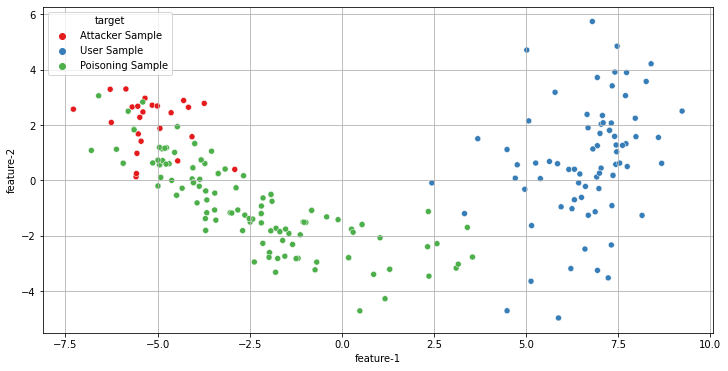

In [23]:
#pca = PCA(n_components=2) 
# Fit pca to 'X'
df1= pd.DataFrame(pca.fit_transform(df.drop(['target'], 1)))
df1.shape

df1['target']= df.target

fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(True)
plt.xlabel('feature-1'); plt.ylabel('feature-2')
sns.scatterplot(x=df1.iloc[:, 0] , y= df1.iloc[:, 1], hue = df1.iloc[:, 2], data= df1, palette='Set1', ax= ax)
plt.show()

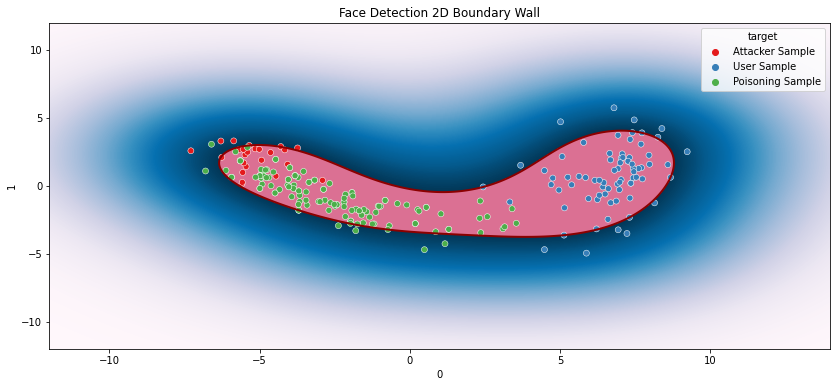

In [24]:
# Excluding (0-24) samples (Attacker side)
clf_pca.fit(df1.iloc[24:, 0:2])

xx, yy = np.meshgrid(np.linspace(-12, 14, 1000), np.linspace(-14, 12, 1000))

# plot the line, the points, and the nearest vectors to the plane
Z = clf_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize= (14, 6))
plt.title("Face Detection 2D Boundary Wall")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 400), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')


sns.scatterplot(x=df1.iloc[:, 0] , y= df1.iloc[:, 1], hue = df1.iloc[:, 2], data= df1, palette='Set1')

plt.axis('tight')
plt.xlim((-12, 14))
plt.ylim((-12, 12))

plt.show()

In [25]:
img=[]
img.append(adv_x[15])
for i in np.linspace(0, len(pubertation_list)-1, 4):
  img.append(load_pubertation(adv_x, pubertation_list, int(i), mask, feature_space= True)[15])

img.append(Target_x[4])
print('Total Sample',len(img))

img_stack= np.hstack((img))
img_stack= np.clip(img_stack, 0, 1)

Total Sample 6


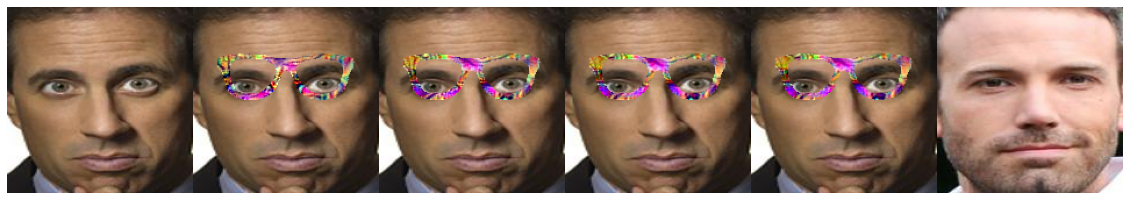

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(img_stack)
plt.axis('off')
plt.show()